In [6]:
import os
from datetime import datetime
import pandas as pd
import numpy as np
from pyproj import Transformer, Geod
import geojson
import re
import matplotlib.pyplot as plt
from pathlib import Path
import time
import requests
import json
import geojson
import pandas as pd
import os


In [7]:
city_name = 'New Haven'
city_latitude = 41.3083  # New Haven latitude
city_longitude = -72.9286  # New Haven longitude
start_year = 1961  # Last 60 years of data
end_year = 2021
max_fire_distance = 650  
season_start_month = 5  # Fire season begins in May
season_end_month = 10   # Fire season ends in October
geodetic_calculator = Geod(ellps='WGS84')
coordinate_transformer = Transformer.from_crs("ESRI:102008", "EPSG:4326")

In [8]:
def get_discovery_date(date_info):
    pattern = r"Listed Wildfire Discovery Date\(s\): ([^|]+)"
    try:
        if not date_info:
            return None
        match = re.search(pattern, date_info)
        if match:
            discovery_dates = match.group(1)
            date_matches = re.findall(r'(\d{4}-\d{2}-\d{2})', discovery_dates)
            if date_matches:
                dates = [datetime.strptime(d, '%Y-%m-%d') for d in date_matches]
                earliest_date = min(dates)
                return earliest_date.strftime('%m/%d/%Y')
    except Exception as e:
        print(f"Date extraction error: {str(e)}")
    return None


In [9]:
def transform_to_latlon(coords):
    converted_coordinates = []
    try:
        for coord in coords:
            if len(coord) >= 2:
                lat, lon = coordinate_transformer.transform(coord[0], coord[1])
                converted_coordinates.append((lat, lon))
    except Exception as e:
        print(f"Coordinate conversion error: {str(e)}")
    return converted_coordinates

In [10]:
# Calculate the minimum distance from fire perimeter to the city
def get_shortest_distance_to_city(fire_coords, city_lat, city_lon):
    try:
        if not fire_coords:
            return None
        distances = [
            geodetic_calculator.inv(city_lon, city_lat, coord[1], coord[0])[2] * 0.00062137 
            for coord in fire_coords
        ]
        return min(distances) if distances else None
    except Exception as e:
        print(f"Distance calculation error: {str(e)}")
        return None

In [11]:
# Check if a given date falls within the fire season (May to October)
def check_fire_season(date_str):
    if not date_str:
        return True
    try:
        date = datetime.strptime(date_str, '%m/%d/%Y')
        return season_start_month <= date.month <= season_end_month
    except:
        print(f"Date parsing error for: {date_str}")
        return True


In [12]:
output_dir = 'fire_analysis_results'
os.makedirs(output_dir, exist_ok=True)
data_file = 'USGS_Wildland_Fire_Combined_Dataset.json'

with open(data_file, 'r') as file:
    fire_dataset = geojson.load(file)

In [13]:
def filter_fire_data(data_file, start_year, end_year, city_latitude, city_longitude, max_fire_distance):
    
    with open(data_file, 'r') as file:
        fire_dataset = geojson.load(file)
    
    results = []
    for feature in fire_dataset['features']:
        attributes = feature['attributes']
        
        if attributes['Assigned_Fire_Type'] != 'Wildfire':
            continue
        
        fire_year = attributes['Fire_Year']
        if not (start_year <= fire_year <= end_year):
            continue
        
        discovery_date = get_discovery_date(attributes['Listed_Fire_Dates'])
        if discovery_date and not check_fire_season(discovery_date):
            continue
        
        ring_data = feature['geometry'].get('rings')
        if not ring_data:
            continue
        
        fire_coords = transform_to_latlon(ring_data[0])
        distance_to_city = get_shortest_distance_to_city(fire_coords, city_latitude, city_longitude)
        if distance_to_city is None or distance_to_city > max_fire_distance:
            continue
        
        fire_size = attributes['GIS_Acres']
        fire_name = attributes['Listed_Fire_Names'].split(',')[0].strip().split('(')[0].strip()
        
        results.append({
            'year': fire_year,
            'fire_name': fire_name,
            'size_acres': fire_size,
            'distance_miles': distance_to_city,
            'discovery_date': discovery_date
        })
    
    fire_data = pd.DataFrame(results)
    return fire_data


In [14]:
fire_data = filter_fire_data(
    data_file=data_file,
    start_year=start_year,
    end_year=end_year,
    city_latitude=city_latitude,
    city_longitude=city_longitude,
    max_fire_distance=max_fire_distance
)

In [15]:
fire_data

,year,fire_name,size_acres,distance_miles,discovery_date
0,1963,COLORED,30.743401,299.749547,07/04/1963
1,1965,ABRAMS MTN,3.978242,358.065766,10/30/1965
2,1965,SANDY BOTT,1.989492,362.727378,07/31/1965
3,1965,SKYLAND,1.989099,344.217657,07/24/1965
4,1965,LEWIS PEAK,0.248821,372.711555,08/17/1965
...,...,...,...,...,...
1647,2020,Needle Fire,0.000163,231.699082,None
1648,2020,No Fire Name Provided,0.000015,177.486197,None
1649,2010,Holiday Fire,1545.863939,499.195387,06/29/2010
1650,2012,PORTER MILLS,4307.800521,431.470787,None


In [16]:
fire_data.to_csv("fire_Data.csv")

## Impact Score

In [183]:
def calculate_fire_impact(fire_entry):
    acres = fire_entry['size_acres']
    distance = fire_entry['distance_miles'] 
    
    if distance < 1:
        distance = 1  
    
    impact_score = acres / (distance**2) # Density of fire felt like an appropriate way to score a wildfire, also it's a unitless.
    return impact_score

In [184]:
fire_data['smoke_impact'] = fire_data.apply(lambda row: calculate_fire_impact(row), axis=1)
fire_data 

,year,fire_name,size_acres,distance_miles,discovery_date,smoke_impact
0,1963,COLORED,30.743401,299.749547,07/04/1963,3.421644e-04
1,1965,ABRAMS MTN,3.978242,358.065766,10/30/1965,3.102884e-05
2,1965,SANDY BOTT,1.989492,362.727378,07/31/1965,1.512103e-05
3,1965,SKYLAND,1.989099,344.217657,07/24/1965,1.678766e-05
4,1965,LEWIS PEAK,0.248821,372.711555,08/17/1965,1.791190e-06
...,...,...,...,...,...,...
1647,2020,Needle Fire,0.000163,231.699082,None,3.030712e-09
1648,2020,No Fire Name Provided,0.000015,177.486197,None,4.840529e-10
1649,2010,Holiday Fire,1545.863939,499.195387,06/29/2010,6.203405e-03
1650,2012,PORTER MILLS,4307.800521,431.470787,None,2.313944e-02


In [187]:
annual_summary = fire_data.groupby('year').agg({
    'size_acres': 'mean',
    'smoke_impact': 'mean',
    'distance_miles': 'mean'
})

In [188]:
annual_summary = annual_summary.reset_index()

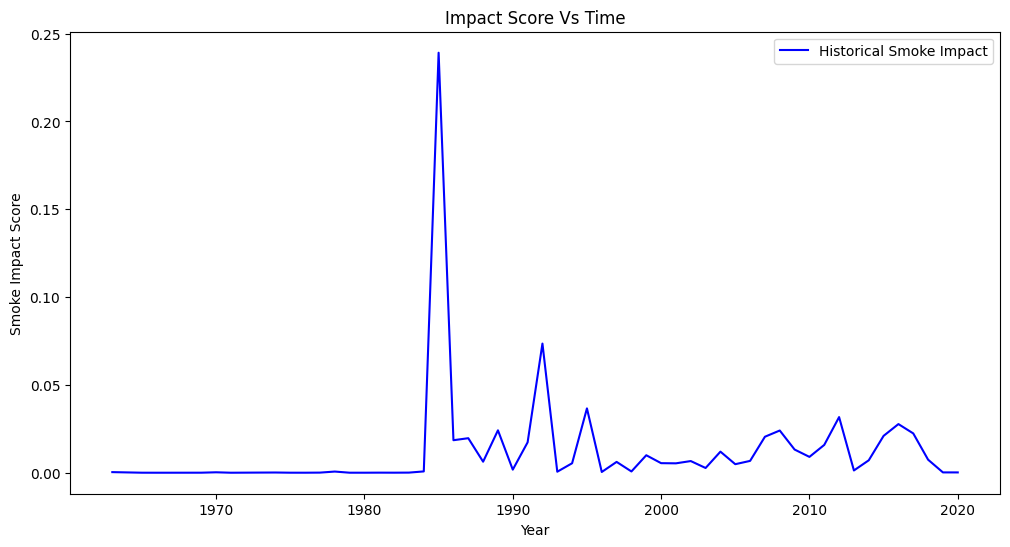

In [195]:
annual_summary
plt.figure(figsize=(12, 6))
plt.plot(annual_summary['year'], annual_summary['smoke_impact'], label='Historical Smoke Impact', color='blue')
plt.xlabel('Year')
plt.ylabel('Smoke Impact Score')
plt.title('Impact Score Vs Time')
plt.legend()
plt.show()

## Loading Data from API

In [137]:
API_BASE_URL = 'https://aqs.epa.gov/data/api'
email = "yasovar@uw.edu"
api_key = "" 

In [138]:
def get_pm25_data(year):
    try:
        params = {
            'email': email,
            'key': api_key,
            'param': 88101,
            'bdate': f'{year}0501',  # May 1st
            'edate': f'{year}1031',  # October 31st
            'state': '09',  
            'county': '009' 
        }
        
        endpoint = '/dailyData/byCounty'
        url = f"{API_BASE_URL}{endpoint}"
        time.sleep(0.02) 
        response = requests.get(url, params=params)
        response.raise_for_status()  
        return response.json()
        
    except requests.exceptions.RequestException as e:
        print(f"API request failed for year {year}: {str(e)}")
        return None
    except Exception as e:
        print(f"Error retrieving PM2.5 data for {year}: {str(e)}")
        return None

## Helper Function for aggregating API results

In [139]:
def calculate_pm25_statistics(aqi_data):
    if not aqi_data or aqi_data.get("Header", [{}])[0].get("status") != "Success":
        return None

    daily_measurements = {}
    for record in aqi_data.get("Data", []):
        value = record.get('arithmetic_mean')
        if value is not None:
            value = float(value)
            date = record['date_local']
            daily_measurements.setdefault(date, []).append(value)

    if not daily_measurements:
        return {'days_with_data': 0, 'mean_pm25': 0.0, 'max_pm25': 0.0}
    
    daily_averages = [sum(values) / len(values) for values in daily_measurements.values()]

    return {
        'days_with_data': len(daily_measurements),
        'mean_pm25': np.mean(daily_averages),
        'max_pm25': max(daily_averages)
    }

## Get API data

In [66]:
import pandas as pd
import json

def obtain_air_quality_metrics(start_year, end_year):
    results = []
    
    for year in range(start_year, end_year + 1):
        print(f"Evaluating data for {year}...")
        
        try:
            # Extract smoke impact and area burned
            smoke_impact = fire_data.loc[fire_data['year'] == year, 'smoke_impact'].values[0]
            area_burned = fire_data.loc[fire_data['year'] == year, 'size_acres'].values[0]
            
            # Get PM2.5 data and statistics
            pm25_data = get_pm25_data(year)
            pm25_stats = calculate_pm25_statistics(pm25_data)
            
            if pm25_stats:
                yearly_result = {
                    'year': year,
                    'smoke_impact_score': smoke_impact,
                    'acres_burned': area_burned,
                    **pm25_stats
                }
                results.append(yearly_result)
        
        except IndexError:
            print(f"No fire data available for {year}. Skipping...")
        
        except Exception as e:
            print(f"An error occurred while processing {year}: {e}")

    return pd.DataFrame(results)


In [68]:
air_index = obtain_air_quality_metrics(1963, 2024)

Evaluating data for 1963...
Evaluating data for 1964...
No fire data available for 1964. Skipping...
Evaluating data for 1965...
Evaluating data for 1966...
Evaluating data for 1967...
Evaluating data for 1968...
No fire data available for 1968. Skipping...
Evaluating data for 1969...
Evaluating data for 1970...
Evaluating data for 1971...
Evaluating data for 1972...
No fire data available for 1972. Skipping...
Evaluating data for 1973...
Evaluating data for 1974...
Evaluating data for 1975...
Evaluating data for 1976...
Evaluating data for 1977...
Evaluating data for 1978...
Evaluating data for 1979...
Evaluating data for 1980...
Evaluating data for 1981...
Evaluating data for 1982...
Evaluating data for 1983...
Evaluating data for 1984...
Evaluating data for 1985...
Evaluating data for 1986...
Evaluating data for 1987...
Evaluating data for 1988...
Evaluating data for 1989...
Evaluating data for 1990...
Evaluating data for 1991...
Evaluating data for 1992...
Evaluating data for 1993.

In [81]:
air_index.to_csv('air_index.csv')
air_index

,year,smoke_impact_score,acres_burned,days_with_data,mean_pm25,max_pm25
0,1999,0.012637,1578.443405,61,14.730238,40.500000
1,2000,0.212925,24183.219032,179,14.855283,46.200000
2,2001,0.002849,482.731373,177,15.623760,48.400000
3,2002,0.015729,2934.206403,161,14.933728,79.400000
4,2003,0.000034,5.015029,174,15.347384,52.200000
5,2004,0.000732,119.077295,178,13.639401,43.200000
6,2005,0.000166,33.022914,175,13.146965,49.300000
7,2006,0.002226,265.637329,181,12.433158,43.328571
8,2007,0.004846,1153.853790,184,12.187499,44.900000
9,2008,0.004254,456.321567,177,11.388288,37.900000


In [140]:
merged_result = pd.merge(annual_summary, air_index, on='year', how='inner')

In [141]:
merged_result

,year,size_acres,smoke_impact,distance_miles,smoke_impact_score,acres_burned,days_with_data,mean_pm25,max_pm25
0,1999,1476.512273,3.564497,451.264024,0.012637,1578.443405,61,14.730238,40.500000
1,2000,1122.923484,3.126008,494.002635,0.212925,24183.219032,179,14.855283,46.200000
2,2001,1456.381405,3.118942,480.157889,0.002849,482.731373,177,15.623760,48.400000
3,2002,505.940633,3.247522,378.616273,0.015729,2934.206403,161,14.933728,79.400000
4,2003,516.736284,2.854322,334.708011,0.000034,5.015029,174,15.347384,52.200000
5,2004,462.576857,3.781048,326.562137,0.000732,119.077295,178,13.639401,43.200000
6,2005,505.747575,3.069532,406.882037,0.000166,33.022914,175,13.146965,49.300000
7,2006,738.810776,3.255844,439.559822,0.002226,265.637329,181,12.433158,43.328571
8,2007,961.778302,4.571725,455.076732,0.004846,1153.853790,184,12.187499,44.900000
9,2008,1984.318300,4.958610,366.843689,0.004254,456.321567,177,11.388288,37.900000


In [142]:
def pm25_to_aqi(pm25):
    if pm25 <= 12:
        return (50/12) * pm25
    elif pm25 <= 35.4:
        return (49/23.4) * (pm25 - 12.1) + 51
    elif pm25 <= 55.4:
        return (49/20) * (pm25 - 35.5) + 101
    elif pm25 <= 150.4:
        return (99/94.9) * (pm25 - 55.5) + 151
    elif pm25 <= 250.4:
        return (99/99.9) * (pm25 - 150.5) + 201
    elif pm25 <= 350.4:
        return (99/99.9) * (pm25 - 250.5) + 301
    elif pm25 <= 500.4:
        return (99/149.9) * (pm25 - 350.5) + 401
    else:
        return 500


merged_result['mean_aqi'] = merged_result['mean_pm25'].apply(pm25_to_aqi)
merged_result['max_aqi'] = merged_result['max_pm25'].apply(pm25_to_aqi)
merged_result

,year,size_acres,smoke_impact,distance_miles,smoke_impact_score,acres_burned,days_with_data,mean_pm25,max_pm25,mean_aqi,max_aqi
0,1999,1476.512273,3.564497,451.264024,0.012637,1578.443405,61,14.730238,40.500000,56.507764,113.250000
1,2000,1122.923484,3.126008,494.002635,0.212925,24183.219032,179,14.855283,46.200000,56.769610,127.215000
2,2001,1456.381405,3.118942,480.157889,0.002849,482.731373,177,15.623760,48.400000,58.378813,132.605000
3,2002,505.940633,3.247522,378.616273,0.015729,2934.206403,161,14.933728,79.400000,56.933875,175.932561
4,2003,516.736284,2.854322,334.708011,0.000034,5.015029,174,15.347384,52.200000,57.800078,141.915000
5,2004,462.576857,3.781048,326.562137,0.000732,119.077295,178,13.639401,43.200000,54.223531,119.865000
6,2005,505.747575,3.069532,406.882037,0.000166,33.022914,175,13.146965,49.300000,53.192362,134.810000
7,2006,738.810776,3.255844,439.559822,0.002226,265.637329,181,12.433158,43.328571,51.697639,120.180000
8,2007,961.778302,4.571725,455.076732,0.004846,1153.853790,184,12.187499,44.900000,51.183224,124.030000
9,2008,1984.318300,4.958610,366.843689,0.004254,456.321567,177,11.388288,37.900000,47.451198,106.880000


# Forecast for future values of smoke impact

/Users/yasovartammareddy/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yasovartammareddy/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/yasovartammareddy/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/qv/3qrv3nmd56s90r_lb6dwy2w00000gn/T/ipykernel_68104/2066185753.py:26: FutureWarning: 'Y' is deprecated and will be removed in a future version, please 

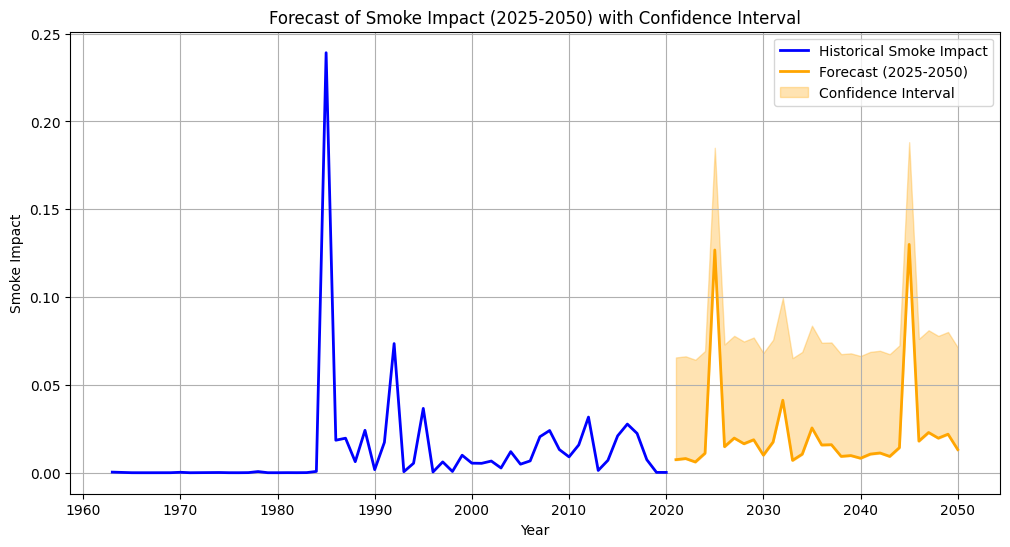

In [219]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

data = annual_summary

data = data[['year', 'smoke_impact']].dropna()
data = data.set_index('year')
data.index = pd.to_datetime(data.index, format='%Y')  


seasonal_period = 20

model = ExponentialSmoothing(
    data['smoke_impact'],
    trend='add',
    seasonal='add',
    seasonal_periods=seasonal_period
).fit()

forecast_values = model.forecast(steps=30)
forecast_index = pd.date_range(start='2020', end='2050', freq='Y')

# Estimate confidence intervals 
forecast_std = forecast_values.std()
forecast_df = pd.DataFrame({
    'year': forecast_index,
    'mean': forecast_values,
    'mean_ci_lower': forecast_values - 0.01 * forecast_std,
    'mean_ci_upper': forecast_values + 1.96 * forecast_std
})


plt.figure(figsize=(12, 6))


plt.plot(data.index, data['smoke_impact'], label='Historical Smoke Impact', color='blue', linewidth=2)
plt.plot(forecast_df['year'], forecast_df['mean'], label='Forecast (2025-2050)', color='orange', linewidth=2)
plt.fill_between(forecast_df['year'], forecast_df['mean_ci_lower'], forecast_df['mean_ci_upper'], color='orange', alpha=0.3, label='Confidence Interval')
plt.xlabel('Year')
plt.ylabel('Smoke Impact')
plt.title(f'Forecast of Smoke Impact (2025-2050) with Confidence Interval')
plt.legend()
plt.grid(True)
plt.show()

# Step 2: Visualize aspects of your analysis


## Visualization 1: Histogram of Fire Distances

In [220]:
fire_distance_1800 = filter_fire_data(
    data_file=data_file,
    start_year=start_year,
    end_year=end_year,
    city_latitude=city_latitude,
    city_longitude=city_longitude,
    max_fire_distance=1800
)

In [222]:
fire_distance_1800.to_csv("fire_distance_1800.csv")
fire_distance_1800 

,year,fire_name,size_acres,distance_miles,discovery_date
0,1961,W_C_H_4_3_W1_61,28.693900,700.890691,None
1,1961,CW_H_4_2_W12_61,6.387265,714.244734,None
2,1961,LIMESTONE,0.018208,1559.136469,08/01/1961
3,1961,COTTONWOOD,0.017406,1561.946160,08/20/1961
4,1961,SO ENCLOSU,0.017405,1560.302269,08/01/1961
...,...,...,...,...,...
15242,2013,WOODPECKER FIRE,511.934267,503.461577,None
15243,2016,RIVER,351.613292,1610.380266,None
15244,2016,FOSS LAKE,7.813279,1044.571644,None
15245,2019,Memorial,2661.472459,666.469663,05/26/2019


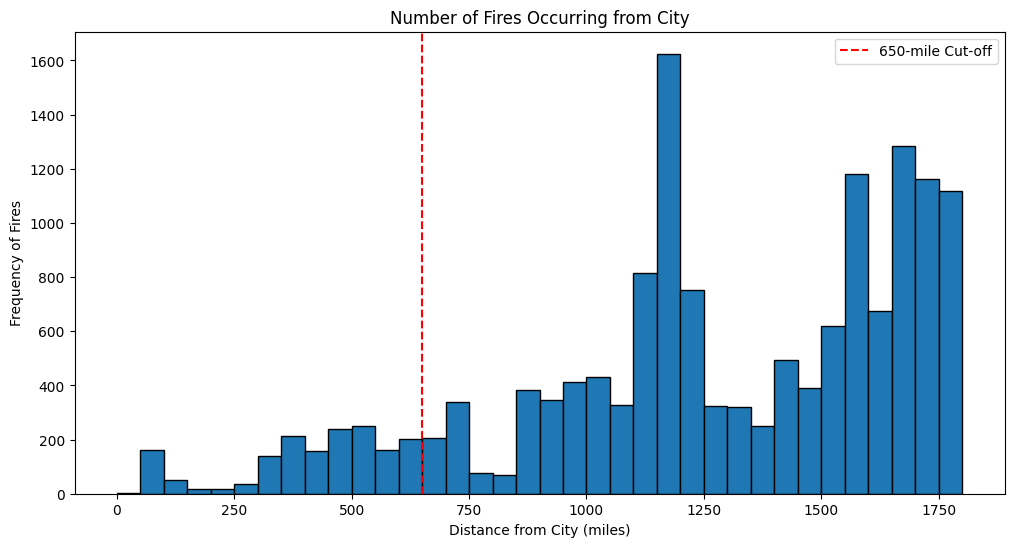

In [229]:
bins = range(0, 1801, 50)
plt.figure(figsize=(12, 6))
plt.hist(fire_distance_1800['distance_miles'], bins=bins, edgecolor='black')
plt.axvline(x=650, color='red', linestyle='--', label='650-mile Cut-off')
plt.xlabel('Distance from City (miles)')
plt.ylabel('Frequency of Fires')
plt.title('Number of Fires Occurring from City')
plt.legend()
plt.show()

## Visualization 2: Time Series of Total Acres Burned

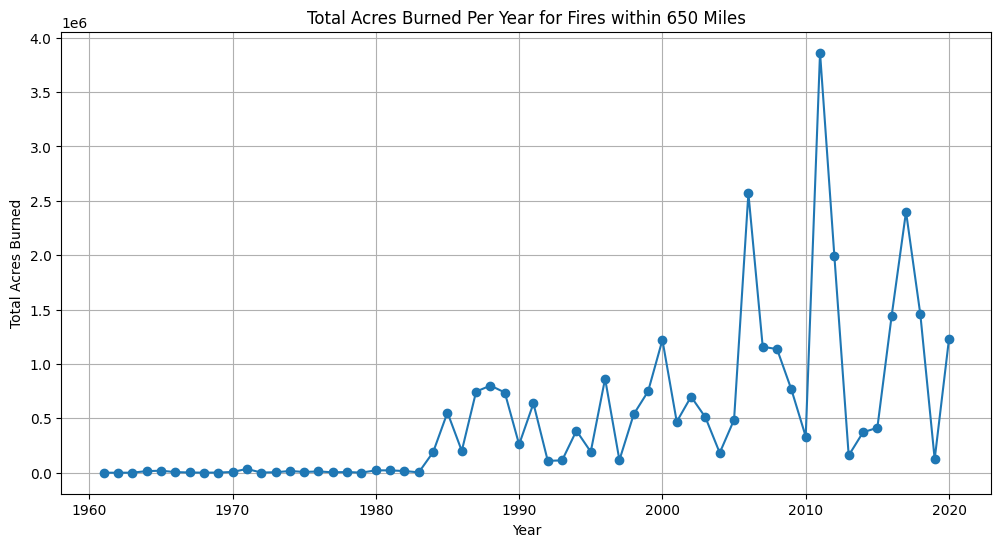

In [225]:
filtered_distance_df = fire_distance_1800[fire_distance_1800['distance_miles'] <= 650]

# Grouping by year and summing the size_acres to get total acres burned per year
acres_burned_per_year = fire_distance_1800.groupby('year')['size_acres'].sum().reset_index()

# Plotting the time series graph
plt.figure(figsize=(12, 6))
plt.plot(acres_burned_per_year['year'], acres_burned_per_year['size_acres'], marker='o')
plt.xlabel('Year')
plt.ylabel('Total Acres Burned')
plt.title('Total Acres Burned Per Year for Fires within 650 Miles')
plt.grid(True)
plt.show()


## Visualization 3


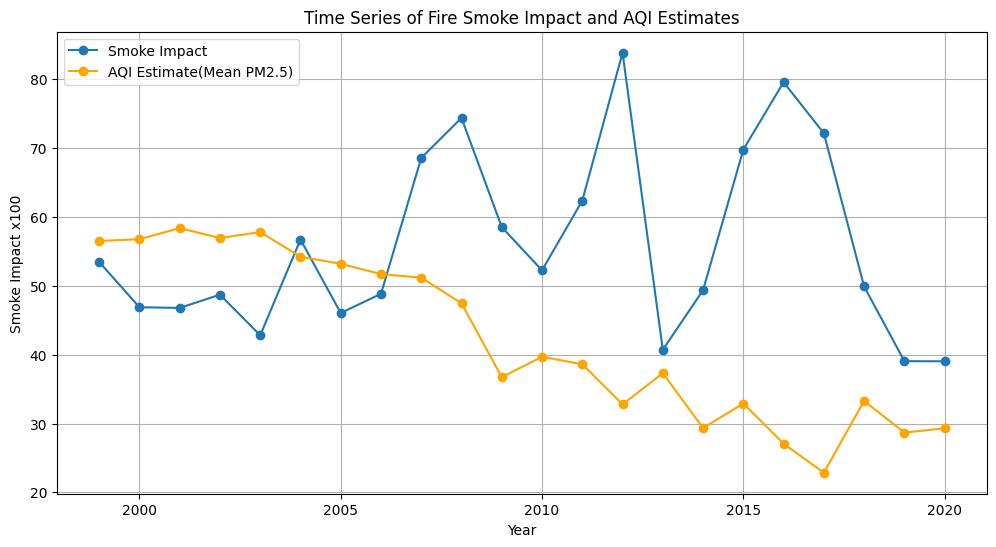

In [234]:
plt.figure(figsize=(12, 6))
plt.plot(merged_result['year'], merged_result['smoke_impact']*15, marker='o', label='Smoke Impact')  
plt.plot(merged_result['year'], merged_result['mean_aqi'], marker='o', color='orange', label='AQI Estimate(Mean PM2.5)')
plt.xlabel('Year')
plt.ylabel('Smoke Impact x100')
plt.title('Time Series of Fire Smoke Impact and AQI Estimates')
plt.legend()
plt.grid(True)
plt.show()
